In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

# Définition inputs

- `meta` : dataframe avec au moins *sub_id*, *age* et *mRS_m3*
- `predictions` : liste de tuples avec 2 entrées :
  1. nom
  2. CSV avec au moins *prediction*
- `index_cols`

In [2]:
meta = pd.read_csv('/NAS/deathrow/vincent/declearn_test/data/stroke/new_exp/metadata.csv')
meta = meta[meta.center!='CHU_Lille']

predictions = (
  ('synthseg_simple_centralized', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_simple_centralized/all.csv'),
  ('synthseg_simple_declearn', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_simple_declearn_decay/all.csv'),
  ('synthseg_simple_lille', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_simple_lille.csv'),
  ('synthseg_augmented_centralized', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_centralized/all.csv'),
  ('synthseg_augmented_declearn', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_declearn_decay/all.csv'),
  ('synthseg_augmented_lille', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/synthseg_lille.csv'),
  ('radiomics_centralized', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/radiomics_centralized/all.csv'),
  ('radiomics_declearn', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/radiomics_declearn_decay/all.csv'),
  ('radiomics_lille', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/radiomics_lille.csv'),
  ('deep_centralized', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/deep_centralized/all.csv'),
  ('deep_declearn', '/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/deep_declearn/all.csv'),
  ('deep_lille','/NAS/deathrow/vincent/declearn_test/predictions/new_predictions/deep_lille.csv'),
)

index_cols = ['sub_id','description']

In [3]:
meta['men'] = meta.sex.replace({'M':1, 'F':0})

/tmp/ipykernel_2273536/879414474.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  meta['men'] = meta.sex.replace({'M':1, 'F':0})


# Chargement des données

On charge une dataframe globale avec toutes les prédictions.

In [4]:
prediction_names = [p[0] for p in predictions]

df = meta.set_index(index_cols)
#df = df[['center','age','mRS_m3']]

for name,pred_path in predictions:
  df_ = pd.read_csv(pred_path, index_col=index_cols)
  df[name+'_pred'] = df_.prediction.loc[df.index]

# Calcul PAD et erreurs

In [5]:
for p in prediction_names:
  df[p+'_pad'] = df[p+'_pred']-df.age
  df[p+'_err'] = abs(df[p+'_pad'])

# Étude des erreurs

## Moyennes, écart-types

In [6]:
for p in prediction_names:
  print(f"{p:30s} -> {df[p+'_err'].mean():.2f} ± {df[p+'_err'].std():.2f}") 

synthseg_simple_centralized    -> 8.27 ± 6.53
synthseg_simple_declearn       -> 8.37 ± 6.63
synthseg_simple_lille          -> 8.84 ± 7.38
synthseg_augmented_centralized -> 7.59 ± 6.06
synthseg_augmented_declearn    -> 7.79 ± 6.21
synthseg_augmented_lille       -> 8.14 ± 6.96
radiomics_centralized          -> 6.86 ± 5.49
radiomics_declearn             -> 7.31 ± 5.83
radiomics_lille                -> 8.55 ± 8.59
deep_centralized               -> 5.91 ± 4.66
deep_declearn                  -> 6.34 ± 5.03
deep_lille                     -> 6.60 ± 5.50


## Paired tests

In [7]:
def wilcoxon_signRank_clust(data, m1, m2, k):
    """
    Performs a two-tailed wilcoxon signed rank test for paired comparisons of clustered data with unequal cluster sizes (Rosner2005).
    PARAMETERS:
        - data: pandas DataFrame
        - m1: column name for the first variable
        - m2: column name for the second variable
        - k: cluster identifier (one or several column names)
    RETURNS:
        The test statistic and the corresponding p-value
    """
    df = data.copy()
    # computation of signed ranks
    df['z'] = df[m1]-df[m2]
    df['rank'] = stats.rankdata(df['z'].abs())*np.sign(df['z'])
    
    # ranks for each cluster
    groups = df.groupby(k)['rank'].apply(np.array).to_list()
    m = len(groups)
    gs = np.array([len(g) for g in groups])
    G = sum(gs)

    # average rank per cluster
    s_bar = np.empty(m)
    for i in range(m): s_bar[i] = np.mean(groups[i])
        
    # empirical variance of global ranking
    mean = np.mean(np.concatenate(groups))
    var_g = sum(np.square(np.concatenate(groups)-mean)) / (G-1)
    
    # estimation of intraclass correlation
    sig2 = sum([sum(np.square(groups[i]-s_bar[i])) for i in range(m)]) / (G-m)
    g0 = (G - sum(np.square(gs))/G) / (m-1)
    sig2a = max((sum([gs[i]*pow(s_bar[i]-mean,2) for i in range(m)])/(m-1)-sig2)/g0, 0)
    ps = max(sig2a/(sig2a+sig2), 0)
    ps_corr = ps*(1+(1-pow(ps,2))/(m-5/2))
    
    # final statistic
    ws = gs / (var_g*(1+(gs-1)*ps_corr))
    t = sum(ws*s_bar) / np.sqrt(sum(np.square(ws*s_bar))) # standard normal distribution under H0
    return t, 2*(1-stats.norm.cdf(abs(t)))

In [8]:
feature_sets = 'synthseg_simple', 'synthseg_augmented', 'radiomics', 'deep'

for set_ in feature_sets:
  stat,p = wilcoxon_signRank_clust(df, f"{set_}_centralized_err", f"{set_}_lille_err", 'sub_id')
  print(f"{set_} -> centralized VS Lille -> stat = {stat:+06.2f}, p = {p:.4f}")
  stat,p = wilcoxon_signRank_clust(df, f"{set_}_centralized_err", f"{set_}_declearn_err", 'sub_id')
  print(f"{set_} -> centralized VS declearn -> stat = {stat:+06.2f}, p = {p:.4f}")
  stat,p = wilcoxon_signRank_clust(df, f"{set_}_lille_err", f"{set_}_declearn_err", 'sub_id')
  print(f"{set_} -> Lille VS declearn -> stat = {stat:+06.2f}, p = {p:.4f}")
  print()

synthseg_simple -> centralized VS Lille -> stat = -04.74, p = 0.0000
synthseg_simple -> centralized VS declearn -> stat = -01.66, p = 0.0973
synthseg_simple -> Lille VS declearn -> stat = +04.62, p = 0.0000

synthseg_augmented -> centralized VS Lille -> stat = -04.83, p = 0.0000
synthseg_augmented -> centralized VS declearn -> stat = -03.15, p = 0.0016
synthseg_augmented -> Lille VS declearn -> stat = +04.69, p = 0.0000

radiomics -> centralized VS Lille -> stat = -10.38, p = 0.0000
radiomics -> centralized VS declearn -> stat = -04.78, p = 0.0000
radiomics -> Lille VS declearn -> stat = +07.39, p = 0.0000

deep -> centralized VS Lille -> stat = -04.79, p = 0.0000
deep -> centralized VS declearn -> stat = -03.15, p = 0.0016
deep -> Lille VS declearn -> stat = +01.93, p = 0.0540



## Erreurs par centre

### Moyennes, écart-types

In [9]:
centers = df.center.value_counts(sort=True).index
df.groupby('center')[[p+'_err' for p in prediction_names]].agg(['mean']).round(2).loc[centers]

,synthseg_simple_centralized_err,synthseg_simple_declearn_err,synthseg_simple_lille_err,synthseg_augmented_centralized_err,synthseg_augmented_declearn_err,synthseg_augmented_lille_err,radiomics_centralized_err,radiomics_declearn_err,radiomics_lille_err,deep_centralized_err,deep_declearn_err,deep_lille_err
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
center,,,,,,,,,,,,
CH_Valenciennes,8.52,8.68,9.53,7.55,7.92,8.53,6.75,7.48,9.15,6.03,6.71,7.01
CH_Lens,8.54,8.78,8.74,8.04,8.35,8.53,7.25,8.03,8.70,6.29,6.51,6.94
GHICL,8.52,8.44,9.71,7.43,7.78,8.26,6.87,7.37,9.28,5.65,5.46,5.87
CH_Roubaix,7.94,7.72,8.55,7.38,7.60,7.98,7.69,7.87,9.44,6.19,7.49,7.64
CH_Dunkerque,7.90,8.06,8.20,7.12,7.26,7.53,6.62,6.84,8.32,6.16,6.04,6.79
CH_Douai,7.96,8.03,8.09,7.40,7.40,7.70,5.47,5.69,6.19,4.89,5.57,5.27
CH_Arras,8.50,8.77,8.83,7.81,7.97,7.79,6.42,7.29,7.41,5.12,5.94,6.05
CH_Maubeuge,7.32,7.67,7.98,7.21,7.24,7.64,6.80,6.85,8.62,6.24,6.33,6.18


### Boxplots

In [10]:
d = {'center':[], 'method':[], 'error':[]}
for _,row in df.iterrows():
  d['center'].extend([row.center for _ in range(len(prediction_names))])
  d['method'].extend(prediction_names)
  d['error'].extend([row[p+'_err'] for p in prediction_names])
df_sns = pd.DataFrame(d)

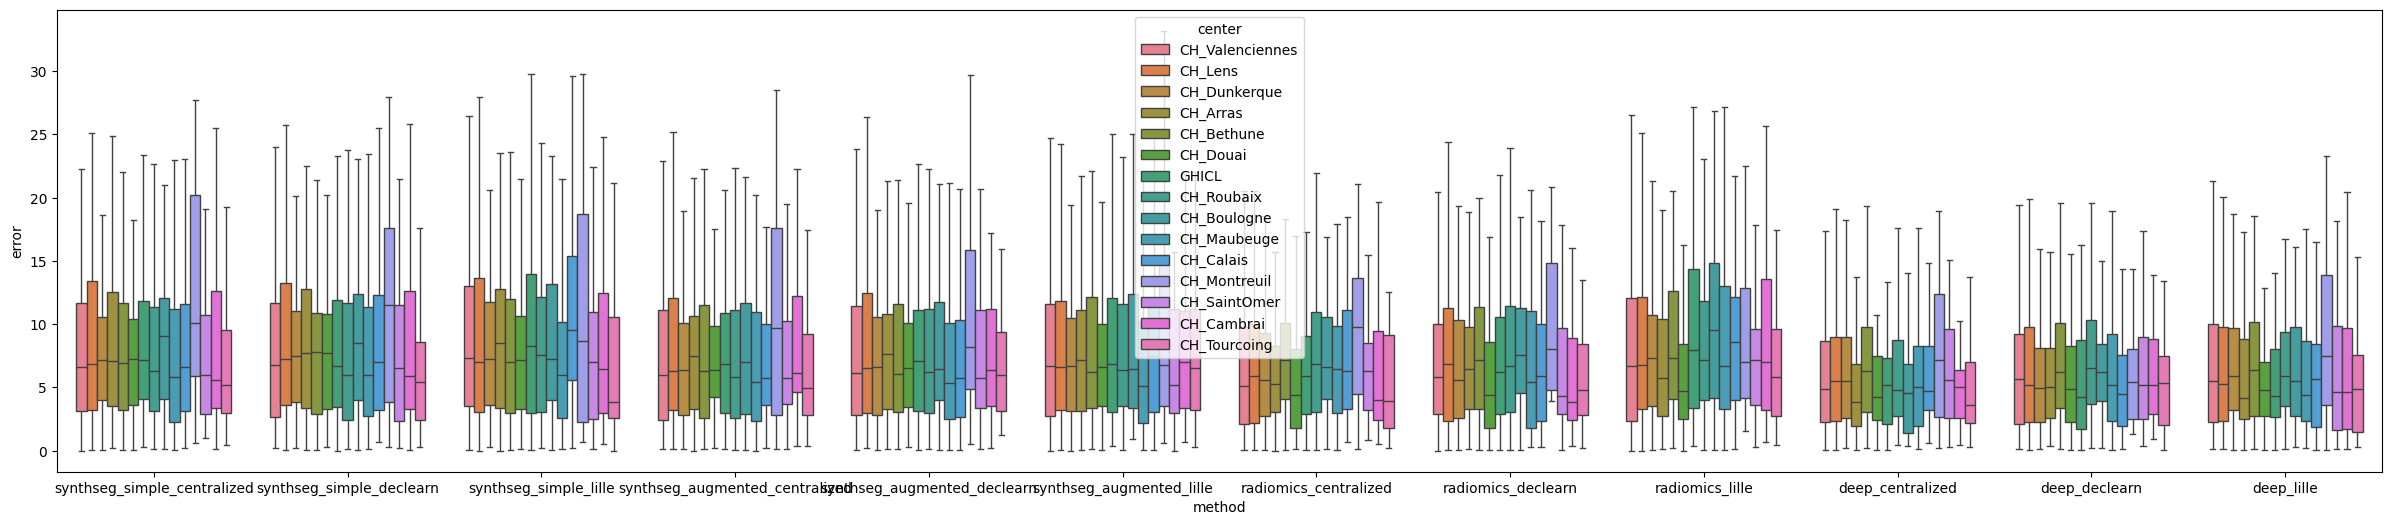

In [11]:
plt.figure(figsize=(30,6))
sns.boxplot(data=df_sns, x='method', y='error', hue='center', showfliers=False, palette=None)
plt.show()

# Étude covariables cliniques

## Correction des PAD

On met en place une validation croisée pour la correction, l'idée est de se rapprocher d'une situation où ou l'on a une nouvelle image qui arrive, et l'on souhaite obtenir son PAD corrigé.

In [12]:
kf = KFold(n_splits=10)
df_trains = []
df_vals = []
df_noIdx = df.reset_index()
df_un = df_noIdx.drop_duplicates('sub_id')

trains = []
vals = []
for train_idx, val_idx in kf.split(df_un):
  trains.append(df_noIdx[df_noIdx.sub_id.isin(df_un.sub_id.iloc[train_idx])])
  vals.append(df_noIdx[df_noIdx.sub_id.isin(df_un.sub_id.iloc[val_idx])].set_index(['sub_id','description']))

for p in prediction_names:
  preds = []
  for df_train,df_val in zip(trains,vals):
    lr = stats.linregress(df_train.age, df_train[p+'_pad'])
    df_val['cpad'] = df_val[p+'_pad'] - lr.intercept - lr.slope*df_val.age
  all_preds = pd.concat(vals)
  df[p+'_cpad'] = all_preds.cpad.loc[df.index]

## Définition groupes bon/mauvais outcome

In [13]:
df_mrs = df[~df.mRS_m3.isna()]
df_mrs['goodOutcome'] = df_mrs.mRS_m3<=2

/tmp/ipykernel_2273536/3137569430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mrs['goodOutcome'] = df_mrs.mRS_m3<=2


## Corrélation avec RBA pour chaque covariable

In [14]:
def wilcoxon_rankSum_clust(data, g_col, v_col, k):
    """
    Performs a two-tailed Wilcoxon rank-sum test as described in doi.org/10.18637/jss.v096.i06 (section 2.1). The method has been proposed initially in doi.org/10.1111/j.0006-341x.2003.00125.x
    Condition: All the individuals within each cluster must belong to the same group.
    PARAMETERS:
        - data: pandas DataFrame
        - g_col: group identifier (one or several column names, must have two unique values)
        - v_col: value of interest
        - k: cluster identifier (one or several column names)
    """
    assert data.groupby(k)[g_col].nunique().eq(1).all()
    df = data.copy()
    uniques = df[g_col].unique()
    assert len(uniques)==2
    df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
    df['rank'] = stats.rankdata(df[v_col])
    clusters = df.groupby(k)
    rip = clusters['rank'].sum()
    groups = clusters[g_col].agg(lambda gs: gs.iloc[0])
    w = (groups*rip).sum()
    
    G = clusters.size().max()
    rpp_g = np.empty(G, dtype='int')
    Ng = np.empty(G, dtype='int')
    ng = np.empty(G, dtype='int')
    mg = np.empty(G, dtype='int')
    var_wg = np.empty(G, dtype='float')
    for g in range(1,G+1):
        clusters2 = clusters.filter(lambda df_: len(df_)==g).groupby(k)
        groups2 = clusters2[g_col].agg(lambda gs: gs.iloc[0])
        rip2 = clusters2['rank'].sum()
        rpp_g[g-1] = (rip2).sum()
        Ng[g-1] = clusters2.ngroups
        ng[g-1] = (groups2==0).sum()
        mg[g-1] = (groups2==1).sum()
        if Ng[g-1]==1: var_wg[g-1] = 0 # not in original paper
        else: var_wg[g-1] = mg[g-1]*ng[g-1]/(Ng[g-1]*(Ng[g-1]-1)) * ((rip2-rpp_g[g-1]/Ng[g-1])**2).sum()
    esp_w = (mg*rpp_g/Ng).sum()
    var_w = var_wg.sum()
    z = (w-esp_w)/np.sqrt(var_w) # standard normal distribution under H0
    return z,2*(1-stats.norm.cdf(abs(z)))

In [15]:
covars = ['men','hta','dm','currentFA','currentSmoke','hyChol']

for c in covars:
  print(c)
  df0 = df_mrs[df_mrs[c]==0]
  df1 = df_mrs[df_mrs[c]==1]
  for pred_name in prediction_names:
    p = wilcoxon_rankSum_clust(df_mrs, c,pred_name+'_cpad','sub_id')[1]
    print(f"{' '*4}{pred_name:22s} -> CPAD_0 = {df0[pred_name+'_cpad'].mean():+06.2f}, CPAD_1 = {df1[pred_name+'_cpad'].mean():+06.2f}, p = {p:.4f}")
  print()

men
    synthseg_simple_centralized -> CPAD_0 = -01.56, CPAD_1 = +01.25, p = 0.0000
    synthseg_simple_declearn -> CPAD_0 = -01.70, CPAD_1 = +01.37, p = 0.0000
    synthseg_simple_lille  -> CPAD_0 = -01.86, CPAD_1 = +01.47, p = 0.0000
    synthseg_augmented_centralized -> CPAD_0 = -01.39, CPAD_1 = +01.22, p = 0.0000
    synthseg_augmented_declearn -> CPAD_0 = -01.50, CPAD_1 = +01.37, p = 0.0000
    synthseg_augmented_lille -> CPAD_0 = -01.56, CPAD_1 = +01.42, p = 0.0000
    radiomics_centralized  -> CPAD_0 = +00.60, CPAD_1 = -00.86, p = 0.0035
    radiomics_declearn     -> CPAD_0 = +00.34, CPAD_1 = -00.48, p = 0.1219
    radiomics_lille        -> CPAD_0 = +00.85, CPAD_1 = -01.12, p = 0.0002
    deep_centralized       -> CPAD_0 = +00.34, CPAD_1 = -00.51, p = 0.0438
    deep_declearn          -> CPAD_0 = +00.49, CPAD_1 = -00.41, p = 0.0624
    deep_lille             -> CPAD_0 = +00.17, CPAD_1 = -00.08, p = 0.7204

hta
    synthseg_simple_centralized -> CPAD_0 = -00.59, CPAD_1 = -00.01, 

## Effet RBA sur résultats fonctionnels

### Comparaison de groupes

#### Informations démographiques

In [16]:
df_mrs.reset_index().groupby('goodOutcome').agg({'sub_id':['count','nunique'], 'age':['mean','std']})

sub_id                age           
             count nunique       mean        std
goodOutcome                                     
False          682     604  72.557185  13.166742
True           356     326  64.853933  14.363726

#### Comparaison pour chaque méthode

In [17]:
df0 = df_mrs[~df_mrs.goodOutcome]
df1 = df_mrs[df_mrs.goodOutcome]
for pred_name in prediction_names:
  p = wilcoxon_rankSum_clust(df_mrs, g_col='goodOutcome', v_col=pred_name+'_cpad', k='sub_id')[1]
  print(f"{pred_name:22s} -> CPAD_0 = {df0[pred_name+'_cpad'].mean():+06.2f}, CPAD_1 = {df1[pred_name+'_cpad'].mean():+06.2f}, p = {p:.4f}")

/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


synthseg_simple_centralized -> CPAD_0 = +00.21, CPAD_1 = -00.95, p = 0.0244
synthseg_simple_declearn -> CPAD_0 = +00.24, CPAD_1 = -01.05, p = 0.0111


/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


synthseg_simple_lille  -> CPAD_0 = +00.11, CPAD_1 = -00.88, p = 0.0446
synthseg_augmented_centralized -> CPAD_0 = +00.45, CPAD_1 = -01.20, p = 0.0043


/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


synthseg_augmented_declearn -> CPAD_0 = +00.42, CPAD_1 = -01.10, p = 0.0104
synthseg_augmented_lille -> CPAD_0 = +00.38, CPAD_1 = -01.03, p = 0.0071


/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


radiomics_centralized  -> CPAD_0 = +00.32, CPAD_1 = -00.94, p = 0.0144
radiomics_declearn     -> CPAD_0 = +00.47, CPAD_1 = -01.07, p = 0.0030


/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


radiomics_lille        -> CPAD_0 = +00.43, CPAD_1 = -01.14, p = 0.0115
deep_centralized       -> CPAD_0 = +00.35, CPAD_1 = -00.88, p = 0.0148


/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)
/tmp/ipykernel_2273536/2703513893.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({uniques[0]:0, uniques[1]:1}, inplace=True)


deep_declearn          -> CPAD_0 = +00.47, CPAD_1 = -00.76, p = 0.0283
deep_lille             -> CPAD_0 = +00.45, CPAD_1 = -00.71, p = 0.0052


### Régression logistique du groupe

In [20]:
import statsmodels.api as sm

covars = ['men','hta','dm','currentFA','currentSmoke','hyChol','nih_h0','age']

for pred_name in prediction_names:
  X = df_mrs[covars+[pred_name+'_cpad']]
  X = sm.add_constant(X)
  logreg = sm.Logit(df_mrs.goodOutcome, X).fit(disp=0)
  preds = logreg.predict(X).to_numpy()
  S = np.diag(preds*(1-preds))
  p1 = np.matmul(X.T, S).to_numpy()
  #print(p1.shape, X.shape)
  # print(p1)
  # print(X)
  p2 = np.matmul(p1, X.to_numpy())
  var = np.diag(np.linalg.inv(p2))
  test_stats = np.square(logreg.params) / var
  pvals = 1 - stats.chi2.cdf(test_stats, 1)
  print(np.round(pvals,3))
  print()
  print(logreg.summary())
  # df_ = pd.DataFrame({
  #   'odds_ratio':np.exp(logreg.params), 'p':logreg.pvalues
  # })
  # print(f"{pred_name}, log-likelihood = {logreg.llf:.6f}")
  # print(df_.iloc[1:].round(4))
  print('\n\n\n')

[0.    0.757 0.072 0.029 0.176 0.156 0.489 0.    0.    0.058]

                           Logit Regression Results                           
Dep. Variable:            goodOutcome   No. Observations:                 1038
Model:                          Logit   Df Residuals:                     1028
Method:                           MLE   Df Model:                            9
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                  0.1240
Time:                        16:14:49   Log-Likelihood:                -584.63
converged:                       True   LL-Null:                       -667.42
Covariance Type:            nonrobust   LLR p-value:                 5.161e-31
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                3.9301      0.495      7.940      0.000       2.960       4.900
me

### Régression logistique : inclusion progressive des AVC sévères

Objectif : Vérifier l'hypothèse que CPAD plus significatif pour outcome sur les AVC peu sévères.

#### Version standardisée sur 1 exemple, affichage de toutes les covariables

In [18]:
features = covars+['radiomics_centralized_cpad']
nih_vals = range(5,45,5)

In [19]:
ors = {c:np.empty(len(nih_vals)) for c in features}

for i,nih in enumerate(nih_vals):
  df_ = df_mrs[df_mrs.nih_h0<=nih]
  X = df_[features]
  X /= X.std()
  X = sm.add_constant(X)
  Y = df_.goodOutcome
  logreg = sm.Logit(Y,X).fit(disp=0)
  ors_ = np.exp(logreg.params)
  for f in features:
    ors[f][i] = ors_[f]

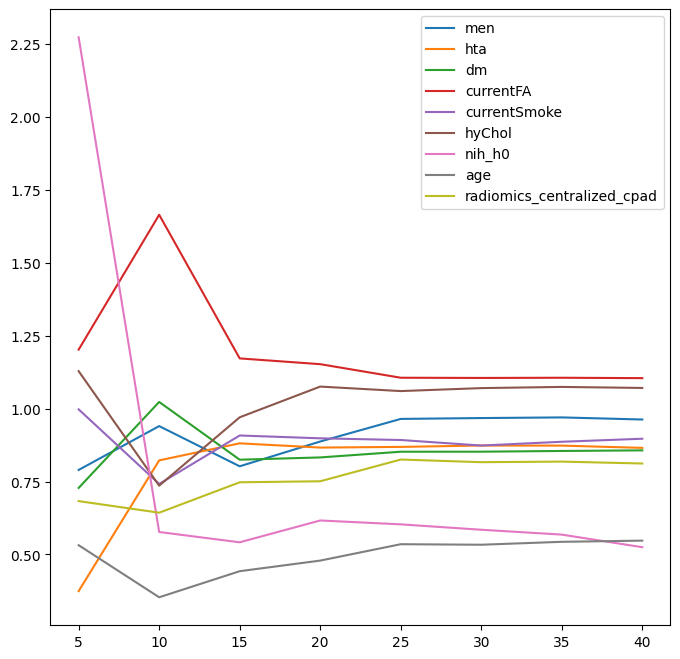

In [20]:
plt.figure(figsize=(8,8))
for covar,vals in ors.items():
  plt.plot(nih_vals,vals, label=covar)
plt.xticks(nih_vals)
plt.legend()
plt.show()

#### Affichage des CPAD pour chaque feature set

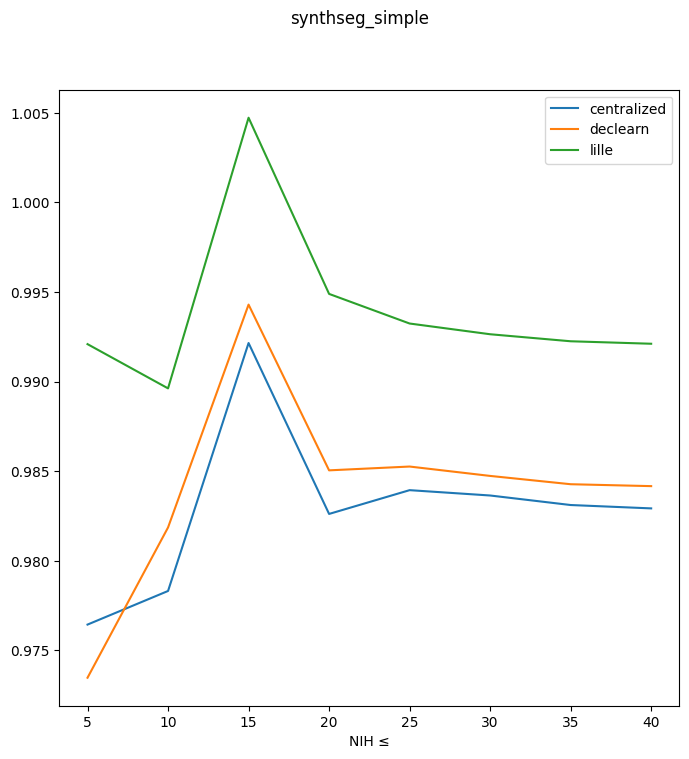

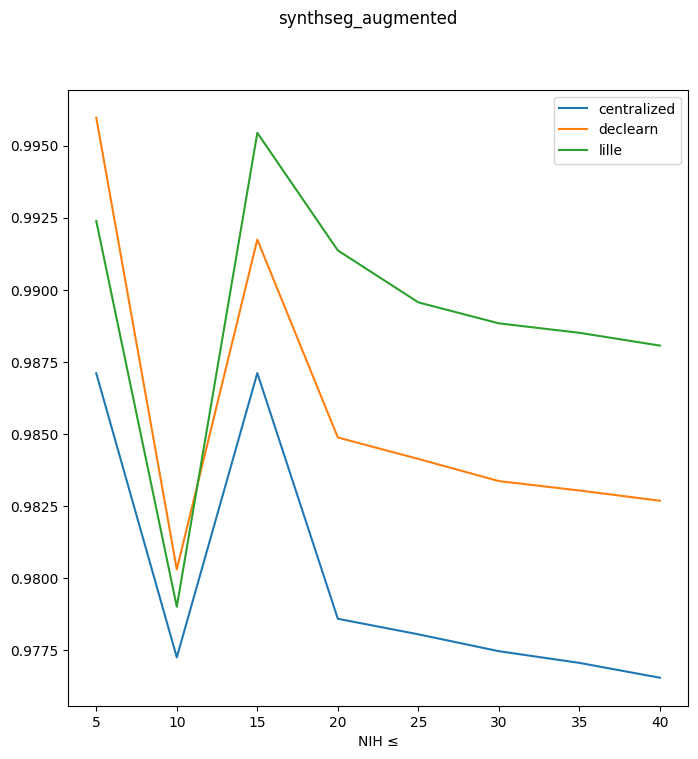

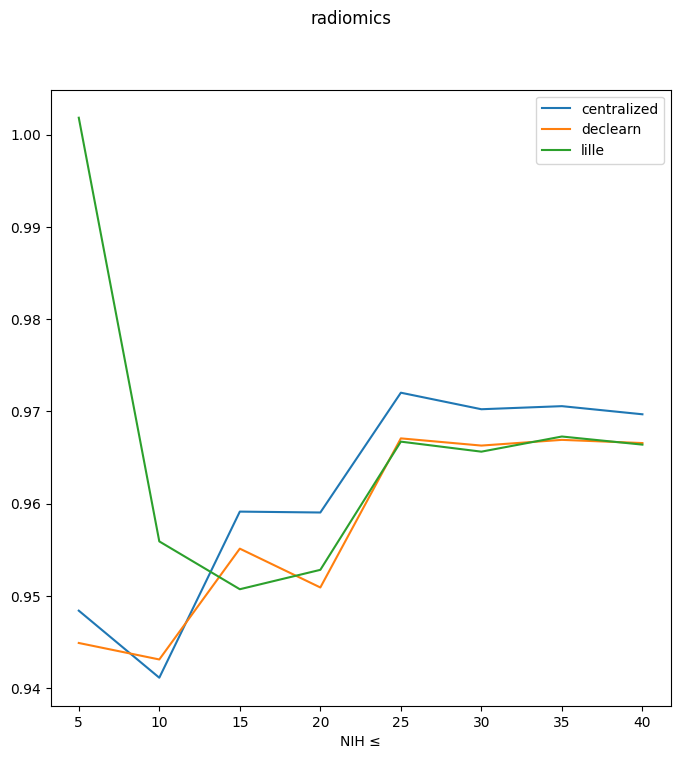

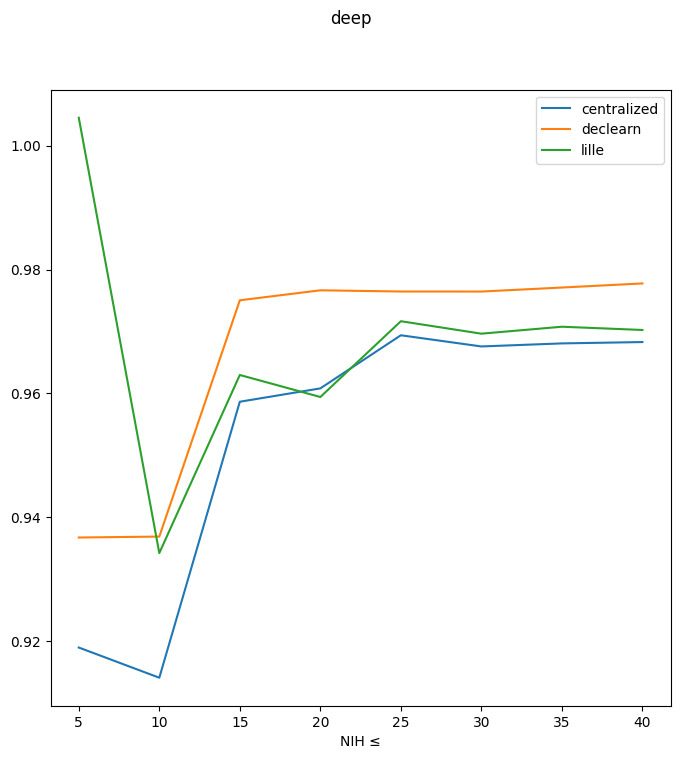

In [21]:
feature_sets = 'synthseg_simple', 'synthseg_augmented', 'radiomics', 'deep'
learning_sets = 'centralized','declearn','lille'
ors = np.empty(len(nih_vals))

for set1 in feature_sets:
  plt.figure(figsize=(8,8))
  plt.suptitle(set1)
  for set2 in learning_sets:
    features = covars+[f'{set1}_{set2}_cpad']
    for i,nih in enumerate(nih_vals):
      df_ = df_mrs[df_mrs.nih_h0<=nih]
      X = df_[features]
      X = sm.add_constant(X)
      Y = df_.goodOutcome
      logreg = sm.Logit(Y,X).fit(disp=0)
      ors[i] = np.exp(logreg.params[f"{set1}_{set2}_cpad"])
    plt.plot(nih_vals, ors, label=set2)
  plt.xlabel('NIH ≤')
  plt.legend()
  plt.show()

## Affichage de 2 sujets exemples

### Sujet CPAD élevé

In [84]:
row = df[df.radiomics_centralized_cpad>12].sample(n=1).iloc[0]
row

center                                 CH_Roubaix
age                                          53.0
mRS_m3                                        NaN
synthseg_simple_centralized_pred        70.118943
synthseg_simple_declearn_pred           69.959558
synthseg_simple_lille_pred              72.316743
synthseg_augmented_centralized_pred     71.849686
synthseg_augmented_declearn_pred        72.110415
synthseg_augmented_lille_pred           73.847419
radiomics_centralized_pred              74.598012
radiomics_declearn_pred                 72.899429
radiomics_lille_pred                    80.272779
deep_centralized_pred                   74.764725
deep_declearn_pred                      72.576889
deep_lille_pred                         76.148796
synthseg_simple_centralized_pad         17.118943
synthseg_simple_centralized_err         17.118943
synthseg_simple_declearn_pad            16.959558
synthseg_simple_declearn_err            16.959558
synthseg_simple_lille_pad               19.316743


In [85]:
path = f'/NAS/coolio/vincent/data/cohorte_AVC/n4brains_regNorm/{row.name[0]}_{row.name[1]}.nii.gz'
mri = nib.load(path).get_fdata()
image = mri[:,:,16]

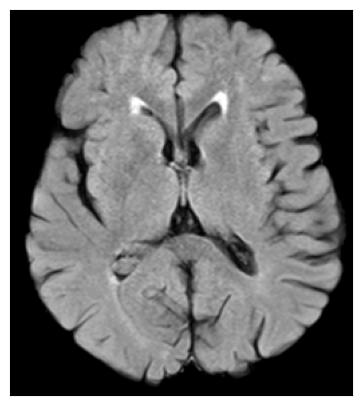

In [87]:
plt.figure(figsize=(7,5))
plt.imshow(np.rot90(image), cmap='gray', vmin=-3, vmax=3)
plt.xticks(())
plt.yticks(())
plt.show()

### Sujet CPAD faible

In [95]:
row = df[df.radiomics_centralized_cpad<-12].sample(n=1).iloc[0]
row

center                                 CH_Montreuil
age                                            67.0
mRS_m3                                          6.0
synthseg_simple_centralized_pred          66.420692
synthseg_simple_declearn_pred             64.823045
synthseg_simple_lille_pred                65.417487
synthseg_augmented_centralized_pred       67.935247
synthseg_augmented_declearn_pred          66.011959
synthseg_augmented_lille_pred             66.431139
radiomics_centralized_pred                57.054091
radiomics_declearn_pred                   61.953743
radiomics_lille_pred                      60.755225
deep_centralized_pred                     64.829697
deep_declearn_pred                        65.658112
deep_lille_pred                           59.851021
synthseg_simple_centralized_pad           -0.579308
synthseg_simple_centralized_err            0.579308
synthseg_simple_declearn_pad              -2.176955
synthseg_simple_declearn_err               2.176955
synthseg_sim

In [96]:
path = f'/NAS/coolio/vincent/data/cohorte_AVC/n4brains_regNorm/{row.name[0]}_{row.name[1]}.nii.gz'
mri = nib.load(path).get_fdata()
image = mri[:,:,16]

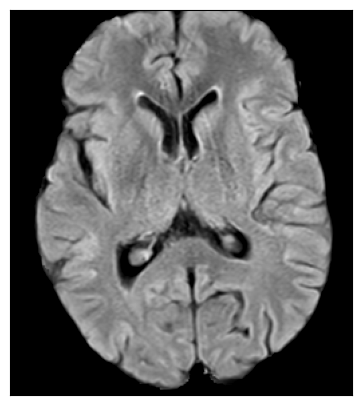

In [97]:
plt.figure(figsize=(7,5))
plt.imshow(np.rot90(image), cmap='gray', vmin=-3, vmax=3)
plt.xticks(())
plt.yticks(())
plt.show()